In [1]:
#!pip install git+https://github.com/tensorflow/docs

In [32]:
import pathlib
import shutil
import tempfile

from   IPython import display
from   matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from   tensorflow.keras import layers, regularizers, Sequential
from   tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from   tensorflow.keras.layers import Dense, Dropout
from   tensorflow.keras.losses import BinaryCrossentropy
from   tensorflow.keras.optimizers import Adam, schedules
import tensorflow_docs as tfdocs
from   tensorflow_docs import modeling, plots

tf.__version__

'2.4.0'

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/'tensorboard_logs'
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
gz = tf.keras.utils.get_file(
    'HIGGS.csv.gz', 
    'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [5]:
FEATURES = 28

In [6]:
ds = tf.data.experimental.CsvDataset(gz, [float(), ] * (FEATURES + 1), 
                                     compression_type='GZIP' )

In [7]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [8]:
packed_ds = ds.batch(10_000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


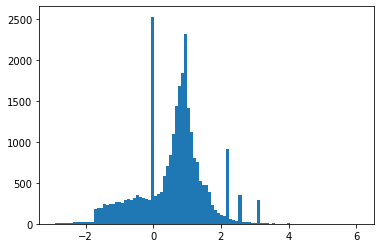

In [9]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [10]:
N_VALID = 1000
N_TRAIN = 10_000
BUFFER = 10_000
BATCH = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH

In [11]:
valid_ds = packed_ds.take(N_VALID).cache()
train_ds = packed_ds.skip(N_VALID).take(N_TRAIN).cache()
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [12]:
valid_ds = valid_ds.batch(BATCH)
train_ds = train_ds.shuffle(BUFFER).repeat().batch(BATCH)

## Overfit Demo

In [13]:
lr_schedule = schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH * 1000,
    decay_rate=1,
    staircase=False)

In [14]:
def get_optimizer():
    return Adam(lr_schedule)

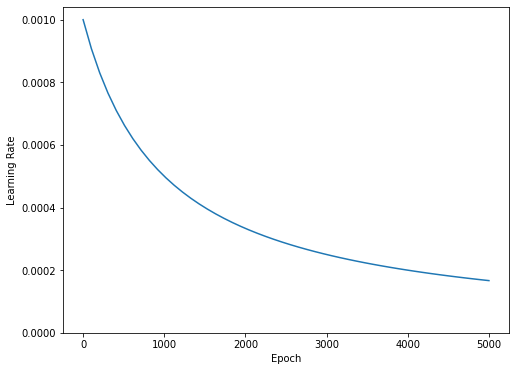

In [15]:
step = np.linspace(0, 100_000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate');

In [16]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        EarlyStopping(monitor='val_bxe', patience=200),
        TensorBoard(logdir/name)]

In [17]:
def compile_and_fit(mod, name, optimizer=None, max_epochs=10_000):
    optimizer = get_optimizer() if optimizer is None else optimizer
    mod.compile(optimizer=optimizer,
               loss=BinaryCrossentropy(from_logits=True),
               metrics=[BinaryCrossentropy(from_logits=True, name='bxe'),
                        'accuracy'])
    mod.summary()
    hist = mod.fit(train_ds,
                   steps_per_epoch=STEPS_PER_EPOCH,
                   epochs=max_epochs,
                   validation_data=valid_ds,
                   callbacks=get_callbacks(name),
                   verbose=0)
    return hist

In [18]:
tiny_mod = Sequential([
    Dense(16, activation='relu', input_shape=(FEATURES,)),
    Dense(1)])

In [19]:
size_histories = {'Tiny': compile_and_fit(tiny_mod, 'sizes/Tiny')}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4745,  bxe:0.8257,  loss:0.8257,  val_accuracy:0.4600,  val_bxe:0.7435,  val_loss:0.7435,  
....................................................................................................
Epoch: 100, accuracy:0.6110,  bxe:0.6187,  loss:0.6187,  val_accuracy:0.5850,  val_bxe:0.6204,  val_loss:0.6204,  
....................................................................................................
Epoch: 200, accuracy:0.6433,  bxe:0.6014,  loss:0.6014,  val_accuracy:0.6120,  val_bxe:0.

(0.5, 0.7)

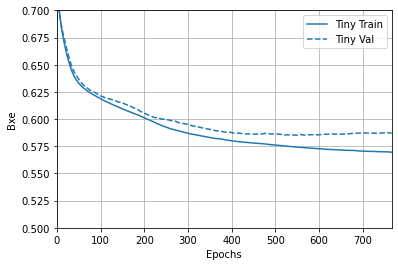

In [20]:
plotter = tfdocs.plots.HistoryPlotter(metric='bxe', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [21]:
small_mod = Sequential([
    Dense(16, activation='relu', input_shape=(FEATURES,)),
    Dense(16, activation='relu'),
    Dense(1)
])

In [22]:
size_histories['Small'] = compile_and_fit(small_mod, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4842,  bxe:0.7061,  loss:0.7061,  val_accuracy:0.4880,  val_bxe:0.6909,  val_loss:0.6909,  
....................................................................................................
Epoch: 100, accuracy:0.6416,  bxe:0.5996,  loss:0.5996,  val_accuracy:0.5920,  val_bxe:0.6257,  val_loss:0.6257,  
........................................................

In [23]:
medium_mod = Sequential([
    Dense(64, activation='relu', input_shape=(FEATURES,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

In [24]:
size_histories['Medium']  = compile_and_fit(medium_mod, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4766,  bxe:0.6908,  loss:0.6908,  val_accuracy:0.4610,  val_bxe:0.6829,  val_loss:0.6829,  
....................................................................................................
Epoch: 100, accuracy:0.8489,  bxe

In [25]:
large_mod = Sequential([
    Dense(512, activation='relu', input_shape=(FEATURES,)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1)
])
size_histories['large'] = compile_and_fit(large_mod, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4749,  bxe:0.6951,  loss:0.6951,  val_accuracy:0.4740,  val_bxe:0.6752,  val_loss:0.6752,  


Text(0.5, 0, 'Epochs [Log Scale]')

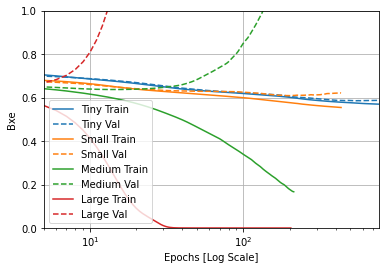

In [26]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0., 1])
plt.xlabel("Epochs [Log Scale]")

### View in TensorBoard

In [27]:
#%load_ext tensorboard
#%tensorboard --logdir {logdir}/sizes

## Preventing Overfitting

In [28]:
# copy Tiny model as baseline
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/var/folders/02/r9r5790n0wz7j9spprbscg100000gp/T/tmp4kh8aepr/tensorboard_logs/regularizers/Tiny')

In [29]:
regularizer_histories = {'Tiny': size_histories['Tiny']}

In [30]:
LAMBDA = 0.001

l2_mod = Sequential([
    Dense(512, 
          activation='elu', 
          kernel_regularizer=regularizers.l2(LAMBDA),
          input_shape=(FEATURES,)),
    Dense(512, 
          activation='elu', 
          kernel_regularizer=regularizers.l2(LAMBDA)),
    Dense(512, 
          activation='elu', 
          kernel_regularizer=regularizers.l2(LAMBDA)),
    Dense(512, 
          activation='elu', 
          kernel_regularizer=regularizers.l2(LAMBDA)),
    Dense(1)])

regularizer_histories['l2'] = compile_and_fit(l2_mod, 'regularizers/l2')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5195,  bxe:0.8370,  loss:2.3670,  val_accuracy:0.4780,  val_bxe:0.6799,  val_loss:2.1385,  


(0.5, 0.7)

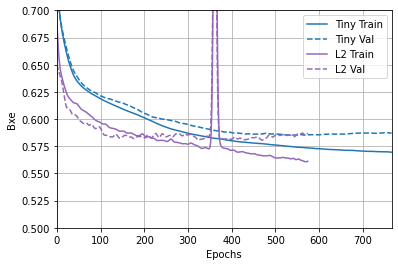

In [31]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [34]:
DROPOUT = 0.5

dropout_mod = Sequential([
    Dense(512, activation='elu', input_shape=(FEATURES,)),
    Dropout(DROPOUT),
    Dense(512, activation='elu'),
    Dropout(DROPOUT),
    Dense(512, activation='elu'),
    Dropout(DROPOUT),
    Dense(512, activation='elu'),
    Dropout(DROPOUT),
    Dense(1)])

In [35]:
regularizer_histories['dropout'] = compile_and_fit(dropout_mod, 
                                                   'regularizers/dropout')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)              

(0.5, 0.7)

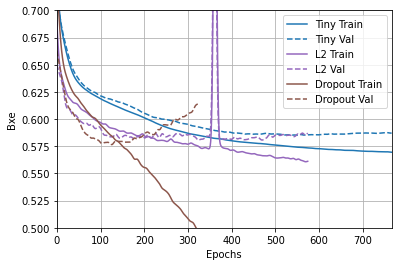

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [43]:
LAMBDA = 0.0001
combo_mod = Sequential([
    Dense(512, 
          kernel_regularizer=regularizers.l2(LAMBDA), 
          activation='elu', 
          input_shape=(FEATURES,)),
    Dropout(DROPOUT),
    Dense(512, 
          kernel_regularizer=regularizers.l2(LAMBDA), 
          activation='elu'),
    Dropout(DROPOUT),
    Dense(512, 
          kernel_regularizer=regularizers.l2(LAMBDA), 
          activation='elu'),
    Dropout(DROPOUT),
    Dense(512, 
          kernel_regularizer=regularizers.l2(LAMBDA), 
          activation='elu'),
    Dropout(DROPOUT),
    Dense(1)])

In [44]:
regularizer_histories['combined'] = compile_and_fit(
    combo_mod, 'regularizers/combined')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)              

(0.5, 0.7)

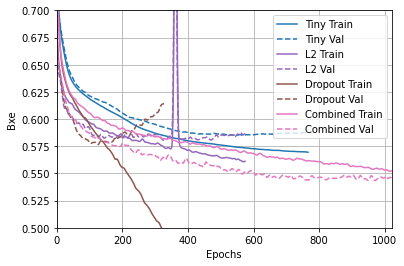

In [45]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Code derived from https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

```
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
```